# Debug learn init

23.08.23

**Motivation:** I'm getting some inconsistent results w/ the learned mu, std when loading in what I thought were the same model weights.

**TO DO:** Debug

In [1]:
import torch
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import json, yaml, os
os.sys.path.append('code')

from plotting import plot_kslots, plot_kslots_iters
from data import make_batch
from model import SlotAttentionPosEmbed

%load_ext autoreload
%autoreload 2

In [2]:
device = 'cpu'

In [3]:
class SlotAttentionLearnInit(torch.nn.Module):
    def __init__(self, 
                 resolution=(32,32),
                 k_slots=3, 
                 hidden_dim=32, 
                 query_dim=32, 
                 n_iter=2,
                 device='cpu',
                 dtype=torch.float32
                 ):
        '''
        Slot attention encoder block with _learnable_ positional embedding

        Inputs:
        - device (cpu, mps, cuda): Which device to put the model on 
                (needed for the random call when initializing the slots)
        - k_slots: number of slots (note, can vary between training and test time)
        - hidden_dim: The hidden dimension for the CNN (currently single layer w/ no non-linearities)
        - query_dim: The latent space dimension that the slots and the queries get computed in
        - n_iter: Number of slot attention steps to apply (defualt 2, and rn hard coded)
        '''
        super().__init__()

        self.k_slots = k_slots
        self.hidden_dim = hidden_dim
        self.query_dim = query_dim
        self.n_iter = n_iter

        self.resolution = resolution
        
        self.device=device
        self.dtype=dtype
        
        self.dataN = torch.nn.LayerNorm(self.hidden_dim)
        self.queryN = torch.nn.LayerNorm(self.query_dim)
        
        self.toK = torch.nn.Linear(self.hidden_dim, self.query_dim)
        self.toV = torch.nn.Linear(self.hidden_dim, self.query_dim)
        self.gru = torch.nn.GRUCell(self.query_dim, self.query_dim)

        
        
        
        filter_size=5
        self.CNN_encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1,self.hidden_dim,filter_size, padding = 2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(self.hidden_dim,self.hidden_dim,filter_size, padding = 2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(self.hidden_dim,self.hidden_dim,filter_size, padding = 2),
        )
        
        self.posEnc = SoftPositionalEmbed(hidden_dim, resolution,device)
        
        self.init_mlp = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim,hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim,hidden_dim)
        )
        
        self.slots_mu = torch.nn.Parameter(torch.randn(1, 1, self.query_dim))
        self.slots_logsigma = torch.nn.Parameter(torch.zeros(1, 1, self.query_dim))
        init.xavier_uniform_(self.slots_logsigma)


    def init_slots(self,Nbatch):
        '''
        Slot init taken from
        https://github.com/lucidrains/slot-attention/blob/master/slot_attention/slot_attention.py
        '''
        mu = self.slots_mu.expand(Nbatch, self.k_slots, -1)
        sigma = self.slots_logsigma.exp().expand(Nbatch, self.k_slots, -1)

        return mu + sigma * torch.randn(mu.shape).to(self.device)

    def encoder(self,data):
        
        # Apply the CNN encoder
        encoded_data = self.CNN_encoder(data)
        
        # Put the channel dim at the end
        encoded_data = torch.permute(encoded_data,(0,2,3,1)) 
                 
        # Add the positional embeddings
        encoded_data = self.posEnc(encoded_data)
        
        # Flatten the pixel dims and apply the data normalization + MLP
        encoded_data = torch.flatten(encoded_data,1,2)
        encoded_data = self.dataN(encoded_data)
        encoded_data = self.init_mlp(encoded_data)
        
        return encoded_data
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients.append( grad )
    
    def attention_and_weights(self,queries,encoded_data):
        keys = self.toK(encoded_data)
        logits = torch.einsum('bse,bde->bsd',queries,keys) * (self.query_dim ** (-0.5)) 
        
        att = torch.nn.functional.softmax(logits, dim = 1)

        if att.requires_grad:
            h = logits.register_hook(self.activations_hook)
        
        div = torch.sum(att, dim = -1, keepdims = True)
        wts = att/div + 1e-8
        return att,wts

    def iterate(self, queries, encoded_data):
        
        # queries: (bs, k_slots, query_dim)
        
        att,wts = self.attention_and_weights(self.queryN(queries),encoded_data)   
        
        # att: (bs, k_slots, img_dim)
        # wts: (bs, k_slots, img_dim)
        
        vals = self.toV(encoded_data) # bs, img_dim, query_dim
        updates = torch.einsum('bsd,bde->bse',wts,vals) # bs, n_slots, query_dim
        
        updates = self.gru(
            updates.reshape(-1,self.query_dim),
            queries.reshape(-1,self.query_dim),
        )

        return updates.reshape(queries.shape)
        
    def forward(self, data):

        self.gradients = []
        
        Nbatch = data.shape[0]
        
        # Initialize the queries
        queries = self.init_slots(Nbatch) # Shape (Nbatch, k_slots, query_dim)
        
        encoded_data = self.encoder(data)
        
        for i in range(self.n_iter):
            queries = self.iterate(queries, encoded_data)    
            
        # Then with the _final_ query vector, calc what the attn + weights would be
        att, wts = self.attention_and_weights(self.queryN(queries),encoded_data)   
            
        return queries, att, wts
    

In [4]:
from model import SoftPositionalEmbed, build_grid
from torch.nn import init

In [5]:
from copy import copy

In [6]:
with open('code/configs/learn-init-warm2.yaml') as f:
    cd = yaml.safe_load(f)

hps_li = copy(cd['hps'])
hps_li['device'] = device
del hps_li['learn_init']
del hps_li['softmax_T']
hps_li

{'hidden_dim': 16, 'k_slots': 3, 'query_dim': 128, 'device': 'cpu'}

In [7]:
m_li = SlotAttentionLearnInit(**hps_li)

In [8]:
weightPath = 'code/models/learn-init-warm/m_44000.pt'

m_li.load_state_dict(torch.load(weightPath,map_location=device))

<All keys matched successfully>

In [9]:
hps_pe = copy(cd['hps'])
hps_pe['device'] = device

In [11]:
m_pe = SlotAttentionPosEmbed(**hps_pe)

m_pe.load_state_dict(torch.load(weightPath,map_location=device))

<All keys matched successfully>

In [12]:
bs = 100
kwargs = cd['data']
X,y, mask = make_batch(N_events=bs, **kwargs)

/gpfs/slac/atlas/fs1/d/nhartman/Slot Attention/code/data.py:97: RuntimeWarning: invalid value encountered in true_divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


In [13]:
from train import hungarian_matching
import torch.nn.functional as F

k_slots=3
max_n_rings=2
resolution=(32,32)

def get_loss(m,X,mask):

    with torch.no_grad():

        queries, att, wts = m(X)

        indices = hungarian_matching(att,mask,bs,k_slots,max_n_rings,resolution[0])

        # Apply the sorting to the predict
        bis=torch.arange(bs).to(device)
        indices=indices.to(device)

        slots_sorted = torch.cat([att[bis,indices[:,0,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)

        flat_mask = mask.reshape(-1,max_n_rings, np.prod(resolution))
        rings_sorted = torch.cat([flat_mask[bis,indices[:,1,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)

        # Calculate the loss
        loss = F.binary_cross_entropy(slots_sorted,rings_sorted,reduction='none').sum(axis=1).mean()

    return loss.item()
        

In [14]:
losses_li = []
losses_pe = []

for i in range(0,44_000,1_000):
    weightPath = f'code/models/learn-init-warm/m_{i}.pt'
    m_li.load_state_dict(torch.load(weightPath,map_location=device))
    m_pe.load_state_dict(torch.load(weightPath,map_location=device))
    
    losses_li.append( get_loss(m_li,X,mask) )
    losses_pe.append( get_loss(m_pe,X,mask) )
    

/gpfs/slac/atlas/fs1/d/nhartman/Slot Attention/code/train.py:41: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272068694/work/torch/csrc/utils/tensor_new.cpp:201.)
  indices = torch.LongTensor(indices)


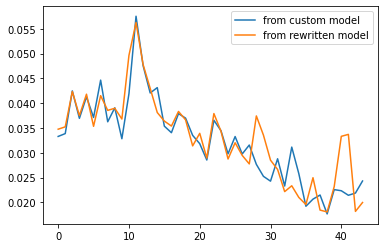

In [15]:
plt.plot(losses_li,label='from custom model')
plt.plot(losses_pe,label='from rewritten model')
plt.legend()
plt.show()

Woooo! Problem _solved_ :) 

The issue was the way I was creating new layers, I was accidentally tying some weights together.

The variance in the loss is due to the random seed in the query creation.